# Predicting car price

## Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import random
random.seed(42)
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette("flare")

In [2]:
# function for calculating the probability of missing variable type for a particular car model

def prob_calc(df):
    probabilities = []
    model = df.index
    
    for values in model:
        probs = []
        count_sum = df.loc[df.index == values].sum().sum()
        count_prob = df.loc[df.index == values].sum()
        for ind in range(len(count_prob)):
            probs.append(count_prob[ind]/count_sum)
        probabilities.append(probs)
        
    return probabilities

In [3]:
try:
    df = pd.read_csv('/Users/anshilina/Documents/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [4]:
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Summary:** According to the descriptive statistics, there are useless features in the data frame. For example, the `NumberOfPictures` variable, that for all observations equals to 0. In addition, variables `DateCrawled`, `DateCreated`, `PostalCode`, `LastSeen` are also seem to be useless, since using them it is impossible to determine the car price.

Moreover, it can be seen that there are outliers in the variables `Price`, `RegistrationYear`, `Power`.

### Outliers

The target variable `Price` has 10.8 thousand observations with zero values. These observations seem to be outliers. Let's drop them from data frame.

In [7]:
display(df['Price'].value_counts().head())

0       10772
500      5670
1500     5394
1000     4649
1200     4594
Name: Price, dtype: int64

In [8]:
df = df.query('Price > 0').copy()
df.shape[0]

343597

There are also outliers in `RegistrationYear` variable: cars could not be registered latter that 2016 since data was uploaded in 2016 (see the unique values of the years in the `DateCrawled` variable). In addition, extrimely large values (`9999` and so on) is the way missing values were encoded – they also will be dropped. Moreover, we assume that vintage cars registered before 1900 are also outliers. There are very few of them in the sample, therefore, we can drop them as well.

In [9]:
print('Number of cars registered before 1900:', df.loc[df['RegistrationYear'] < 1900].shape[0])

Number of cars registered before 1900: 53


In [10]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
print('Years:', df['DateCrawled'].dt.year.unique())

Years: [2016]


In [11]:
df = df.loc[(df['RegistrationYear'] <= 2016) & (df['RegistrationYear'] > 1900)].copy()
display(df.shape)

(329765, 16)

The `Power` variable also contains outliers. They distort the distribution as can be seen from the box plot. Let's remove 1% of the outliers calculating in the lower and upper quantiles.

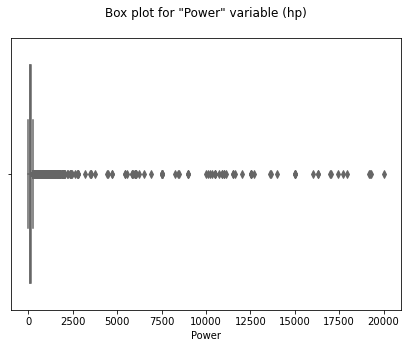

In [12]:
plt.figure(figsize=(7,5))
sns.boxplot(x = df['Power'], palette=color)
plt.xlabel('Power')
plt.title('Box plot for "Power" variable (hp)\n')
plt.show()

In [13]:
lower_quantile = df['Power'].quantile(0.005)
upper_quantile = df['Power'].quantile(0.995)

What is more, power must be different from zero, for a car - 30 hp. minimum.

In [14]:
lower_quantile, upper_quantile

(0.0, 334.0)

In [15]:
df = df.query('30  < Power < @upper_quantile').copy()
df.shape[0]

294305

Let's study final distribution.

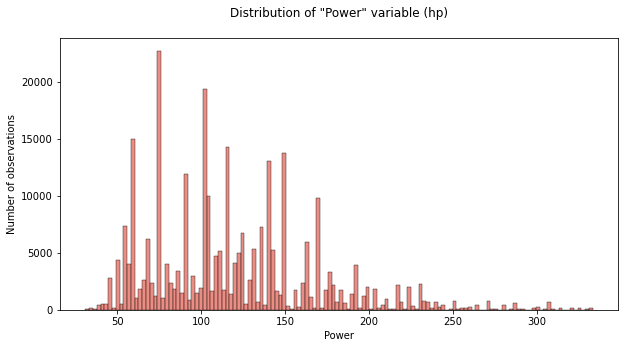

In [16]:
plt.figure(figsize=(10,5))
sns.histplot(x = df['Power'], color=color[1])
plt.xlabel('Power')
plt.ylabel('Number of observations')
plt.title('Distribution of "Power" variable (hp)\n')
plt.show()

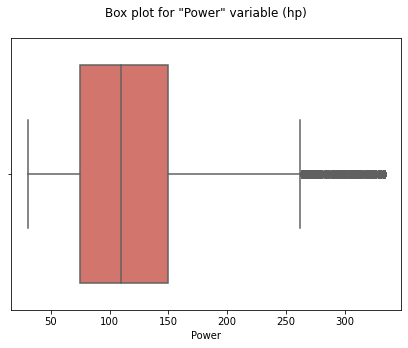

In [17]:
plt.figure(figsize=(7,5))
sns.boxplot(x = df['Power'], color=color[1])
plt.xlabel('Power')
plt.title('Box plot for "Power" variable (hp)\n')
plt.show()

The variable `Kilometer` (mileage) is discrete. Cars are grouped by mileage. There are no outliers in the data - it looks quite realistic.

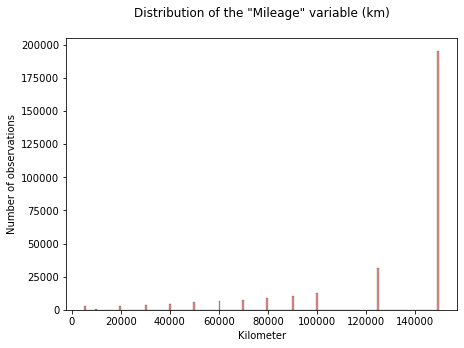

In [18]:
plt.figure(figsize=(7,5))
sns.histplot(x=df['Kilometer'], color=color[1])
plt.ylabel('Number of observations')
plt.xlabel('Kilometer')
plt.title('Distribution of the "Mileage" variable (km)\n')
plt.show()

In [19]:
display(df['Kilometer'].value_counts())

150000    195465
125000     31647
100000     12751
90000      10248
80000       8981
70000       7740
60000       6763
50000       5585
40000       4438
30000       3841
20000       3193
5000        2771
10000        882
Name: Kilometer, dtype: int64

### Assessing feature importance

Now let's assess features importance and drop useless variables. For instance, the `NumberOfPictures` variable takes only one value for all observations - zero. Let's remove it from data frame.

In [20]:
print('Unique values of "NumberOfPictures" variable:', df['NumberOfPictures'].unique())

Unique values of "NumberOfPictures" variable: [0]


The `DateCrawled` variable shows us that all records were downloaded in March-April 2016. This variable is also useless and will not benefit the models. Let's delete it.

In [21]:
print('Years:', df['DateCrawled'].dt.year.unique())
print('Months:', df['DateCrawled'].dt.month.unique())

Years: [2016]
Months: [3 4]


Regarding `LastSeen` variable, it is also useless. The last time all users were active in March-April 2016. Let's remove this variable from data frame.

In [22]:
df['LastSeen'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
print('Years:', df['LastSeen'].dt.year.unique())
print('Months:', df['LastSeen'].dt.month.unique())

Years: [2016]
Months: [3 4]


At first glance, the `DateCreated` variable is more usefull than the three features discussed earlier. All user profiles were created in 2016 or 2015 in different months. But most of the users posted information on cars in March-April: the variance in months is small. Therefore, let's remove this variable as well.

In [23]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')
print('Years:', df['DateCreated'].dt.year.unique())
print('Months:', df['DateCreated'].dt.month.unique())

Years: [2016 2015]
Months: [ 3  4  2 11  1 12  9  8]


In [24]:
display(df['DateCreated'].dt.month.value_counts())

3     246195
4      47682
2        347
1         58
11         9
12         9
9          3
8          2
Name: DateCreated, dtype: int64

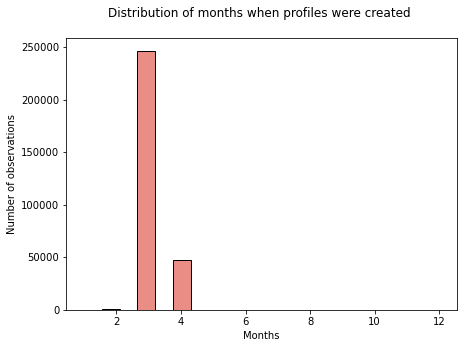

In [25]:
plt.figure(figsize=(7,5))
sns.histplot(x=df['DateCreated'].dt.month, color=color[1])
plt.ylabel('Number of observations')
plt.xlabel('Months')
plt.title('Distribution of months when profiles were created \n')
plt.show()

Therefore, let's drop `NumberOfPictures`, `DateCrawled`, `DateCreated`, `PostalCode`, `LastSeen` variables.

In [26]:
df = df.drop(['NumberOfPictures', 'DateCrawled', 'LastSeen', 'DateCreated', 'PostalCode'], axis=1).copy()

Let's study at the remained numerical variables.

In [27]:
display(df.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,294305.00000,294305.000000,294305.000000,294305.000000,294305.000000
mean,4820.69502,2002.860947,119.638759,128430.165984,5.994869
std,4581.91345,6.438493,50.584339,36603.560360,3.583128
min,1.00000,1910.000000,31.000000,5000.000000,0.000000
25%,1300.00000,1999.000000,75.000000,125000.000000,3.000000
50%,3150.00000,2003.000000,110.000000,150000.000000,6.000000
75%,6980.00000,2007.000000,150.000000,150000.000000,9.000000
max,20000.00000,2016.000000,333.000000,150000.000000,12.000000


### Duplicates

Next, let's analyze duplicates and drop them if necessary.

In [28]:
print('Number of duplicates:', df.duplicated().sum())

Number of duplicates: 23026


In [29]:
df.drop_duplicates(inplace=True)

Having studied the categorical variables, we made sure that there are no errors and repetitions in the values of these variables.

In [30]:
display(df['VehicleType'].value_counts())

sedan          75489
small          64029
wagon          53978
bus            24371
convertible    17255
coupe          13464
suv             9754
other           2322
Name: VehicleType, dtype: int64

In [31]:
display(df['Gearbox'].value_counts())

manual    213233
auto       52928
Name: Gearbox, dtype: int64

In [32]:
display(pd.unique(df['Model'].sort_values()))

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [33]:
display(df['FuelType'].value_counts())

petrol      171366
gasoline     79947
lpg           4213
cng            448
hybrid         196
other           53
electric        37
Name: FuelType, dtype: int64

In [34]:
display(df['Repaired'].value_counts())

no     203537
yes     27361
Name: Repaired, dtype: int64

In [35]:
display(df['Brand'].value_counts())

volkswagen        58352
opel              29791
bmw               29300
mercedes_benz     25089
audi              23096
ford              19160
renault           12870
peugeot            8683
fiat               7017
seat               5413
skoda              4577
mazda              4412
smart              4195
citroen            3950
toyota             3786
nissan             3765
hyundai            2894
mini               2724
volvo              2593
mitsubishi         2369
honda              2249
kia                1937
alfa_romeo         1864
suzuki             1841
sonstige_autos     1473
chevrolet          1355
chrysler           1083
dacia               743
subaru              615
daihatsu            576
jeep                551
saab                439
porsche             436
land_rover          432
jaguar              392
daewoo              385
lancia              358
rover               343
lada                148
trabant              23
Name: Brand, dtype: int64

**Вывод:** Мы проанализировали выбросы в данных и избавились от них. Также мы выявили бессодержательные переменные и удалили их. Наконец, мы обработали дубликаты. После первичного этапа пребодработки данных в массиве осталось белее 280 тыс. наблюдений.

**Summary:** We analyzed data and revealed outliers. We also identified missing values and removed them. Finally, we have processed the duplicates. As the result, more than 270 thousand observations remained in the array.

In [36]:
print('Number of observation in data frame:', df.shape)

Number of observation in data frame: (271279, 11)


Let's visualize distributions of the variables.

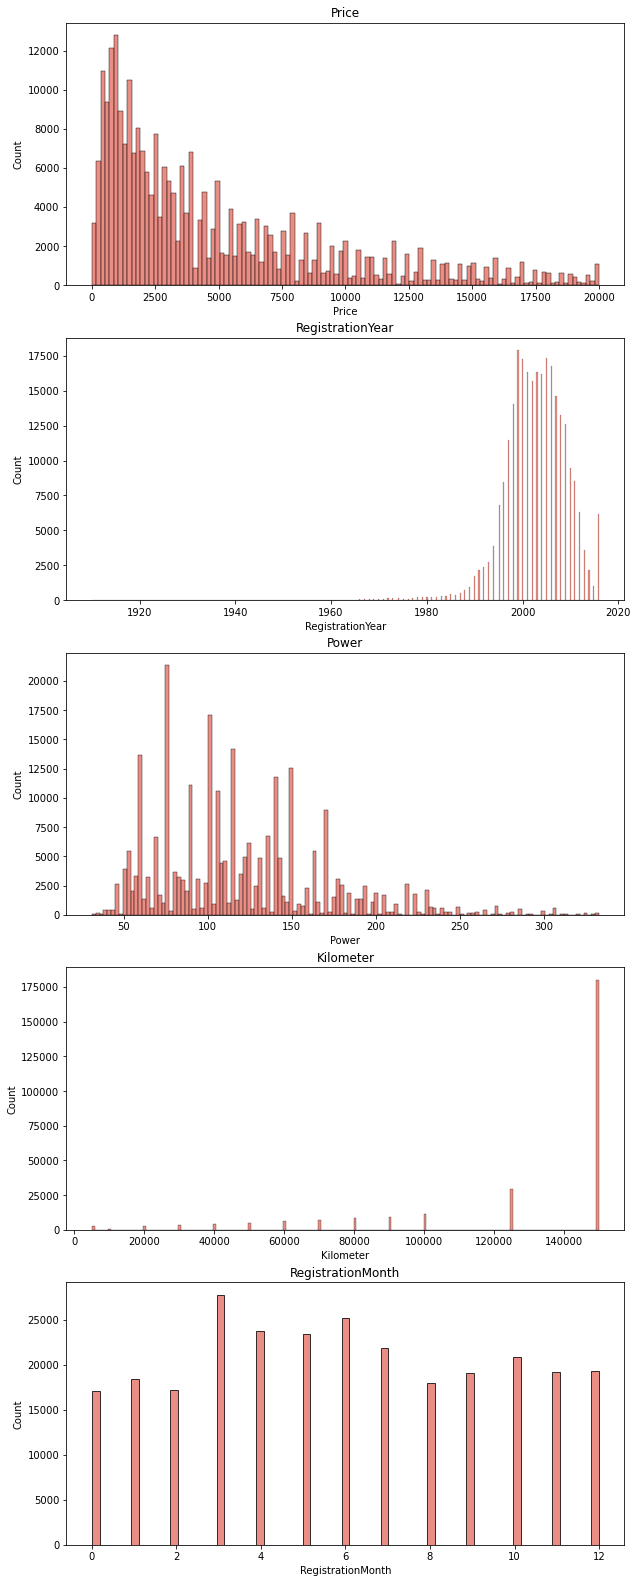

In [37]:
_, axs = plt.subplots(5, 1, figsize=(10,28))
axs = axs.ravel()
col_names = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

for i in range(len(col_names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df[col_names[i]], data=df, color=color[1])
    ax.tick_params(axis='x')
    ax.set_title(col_names[i])

Now let's observe distribution of target variable in groups of categorical variables.

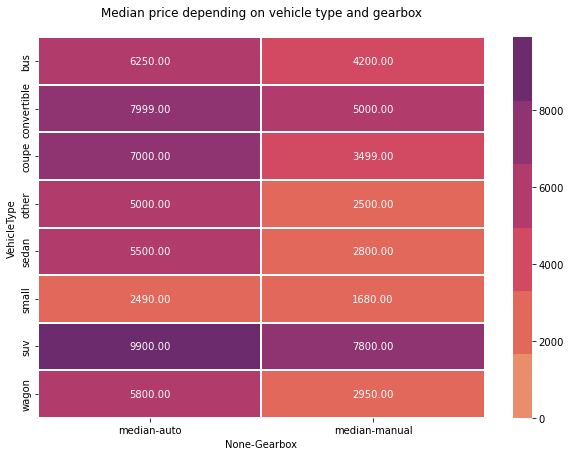

In [39]:
plt.figure(figsize=(10,7))
df_heatmap_gearbox = df.pivot_table(values='Price', index='VehicleType',columns='Gearbox', aggfunc={'median'})

sns.heatmap(df_heatmap_gearbox, annot=True, vmin=0, fmt='.2f', cmap = color, linewidths=0.01)
plt.title('Median price depending on vehicle type and gearbox\n')
plt.show()

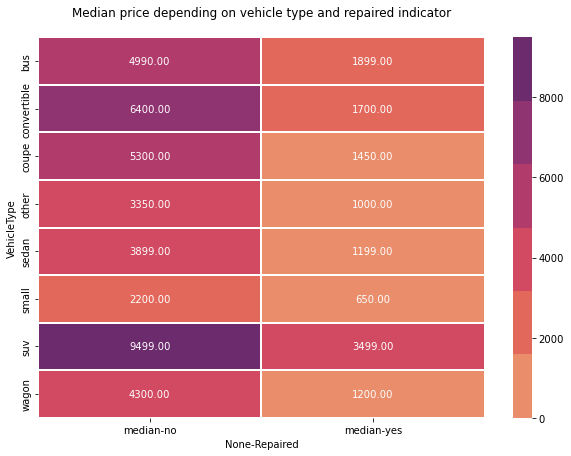

In [42]:
plt.figure(figsize=(10,7))
df_heatmap_repaired = df.pivot_table(values='Price', index='VehicleType',columns='Repaired', aggfunc={'median'})

sns.heatmap(df_heatmap_repaired, annot=True, vmin=0, fmt='.2f', cmap = color, linewidths=0.01)
plt.title('Median price depending on vehicle type and repaired indicator\n')
plt.show()

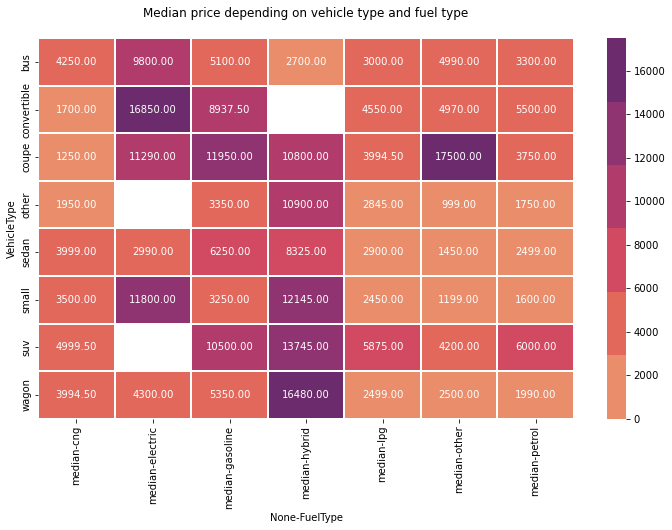

In [43]:
plt.figure(figsize=(12,7))
df_heatmap_fuel = df.pivot_table(values='Price', index='VehicleType',columns='FuelType', aggfunc={'median'})

sns.heatmap(df_heatmap_fuel, annot=True, vmin=0, fmt='.2f', cmap = color, linewidths=0.01)
plt.title('Median price depending on vehicle type and fuel type\n')
plt.show()

### Missing values preprocessing

There are a lot of missing values in the data frame. Before fitting models, we should preprocess it.

In [44]:
display(pd.DataFrame(round(df.isna().sum()), columns=['missing_val']).style.background_gradient(cmap='flare'))

,missing_val
Price,0
VehicleType,10617
RegistrationYear,0
Gearbox,5118
Power,0
Model,10393
Kilometer,0
RegistrationMonth,0
FuelType,15019
Brand,0


#### Model

Depending on the car model, we can fill the missing values in the `VehicleType`, `Gearbox`, `FuelType` and `Repaired` variables. Therefore, at first stage we need to preprocess missing values in `Model` variable. They account for 4.2% of all observations. Let's just drop them from data.

In [47]:
print('Proportion of "Model" missing values from all observations:', df.loc[df['Model'].isna()].shape[0]/df.shape[0])

Proportion of "Model" missing values from all observations: 0.03831111143877705


In [48]:
df = df.loc[~df['Model'].isna()].copy()
display(df.shape)

(260886, 11)

In [49]:
display(pd.DataFrame(round(df.isna().sum()), columns=['missing_val']).style.background_gradient(cmap='flare'))

,missing_val
Price,0
VehicleType,9095
RegistrationYear,0
Gearbox,4469
Power,0
Model,0
Kilometer,0
RegistrationMonth,0
FuelType,12458
Brand,0


#### Repaired

Regarding `Repaired` variable, let's replace missing values with the `unknown` value.

In [50]:
display(df['Repaired'].value_counts())

no     198124
yes     25942
Name: Repaired, dtype: int64

In [51]:
df['Repaired'] = df['Repaired'].fillna('unknown')
display(df['Repaired'].unique())

array(['unknown', 'no', 'yes'], dtype=object)

In [52]:
display(pd.DataFrame(round(df.isna().sum()), columns=['missing_val']).style.background_gradient(cmap='flare'))

,missing_val
Price,0
VehicleType,9095
RegistrationYear,0
Gearbox,4469
Power,0
Model,0
Kilometer,0
RegistrationMonth,0
FuelType,12458
Brand,0


#### FuelType

Missing values in the `FuelType` variable will be filled in depending on what values the car model takes. To begin with, we will group data by `Model` and `FuelType` variables in a pivot table.

In [53]:
display(df['FuelType'].value_counts())

petrol      165569
gasoline     78185
lpg           3985
cng            436
hybrid         175
other           43
electric        35
Name: FuelType, dtype: int64

In [54]:
fuel_type = (
    df.loc[~df['FuelType'].isna(), ['Model', 'FuelType', 'Price']]
    .pivot_table(index=['Model'], columns='FuelType', values='Price', aggfunc={'count'})
)

fuel_type.columns = ['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol']
display(fuel_type.head())

,cng,electric,gasoline,hybrid,lpg,other,petrol
Model,,,,,,,
100,NaN,NaN,13.0,NaN,6.0,NaN,291.0
145,NaN,NaN,NaN,NaN,NaN,NaN,33.0
147,NaN,NaN,107.0,NaN,13.0,NaN,335.0
156,NaN,NaN,155.0,NaN,14.0,NaN,301.0
159,NaN,NaN,127.0,NaN,NaN,NaN,52.0


Next, we will calculate the probability of each fuel type occurrence depending on the car model. To calculate probabilities, we will use the `prob_calc` function, which was initialized at the beginning.

In [55]:
probabilities = prob_calc(fuel_type)

In [56]:
fuel_type_probs = pd.DataFrame(probabilities, index=fuel_type.index, columns=fuel_type.columns)
display(fuel_type_probs.head())

,cng,electric,gasoline,hybrid,lpg,other,petrol
Model,,,,,,,
100,0.0,0.0,0.041935,0.0,0.019355,0.0,0.938710
145,0.0,0.0,0.000000,0.0,0.000000,0.0,1.000000
147,0.0,0.0,0.235165,0.0,0.028571,0.0,0.736264
156,0.0,0.0,0.329787,0.0,0.029787,0.0,0.640426
159,0.0,0.0,0.709497,0.0,0.000000,0.0,0.290503


Let's create function for filling the missing values in `FuelType` variable, depending on the model of the car. Fuel type will be selected randomly depending on the probability of this fuel type occurance in data for the particular car model.

In [57]:
def random_fuel(rows):
    model = rows['Model']
    
    for probs in fuel_type_probs.loc[fuel_type_probs.index == model].values:
        return np.random.choice(fuel_type_probs.columns.values, p=probs)


In [58]:
df.loc[df['FuelType'].isna(), 'FuelType'] = df.loc[df['FuelType'].isna()].apply(random_fuel, axis=1)

Distribution of values didn't change.

In [59]:
display(df['FuelType'].value_counts())

petrol      174342
gasoline     81659
lpg           4159
cng            463
hybrid         182
other           45
electric        36
Name: FuelType, dtype: int64

In [60]:
display(pd.DataFrame(round(df.isna().sum()), columns=['missing_val']).style.background_gradient(cmap='flare'))

,missing_val
Price,0
VehicleType,9095
RegistrationYear,0
Gearbox,4469
Power,0
Model,0
Kilometer,0
RegistrationMonth,0
FuelType,0
Brand,0


#### Gearbox

Let's fill the missing values in `Gearbox` using the same technique as for `FuelType` variable.

In [61]:
display(df['Gearbox'].value_counts())

manual    205459
auto       50958
Name: Gearbox, dtype: int64

In [62]:
gearbox_type = (
    df.loc[~df['Gearbox'].isna(), ['Gearbox', 'Model', 'Price']]
    .pivot_table(index=['Model'], columns='Gearbox', values='Price', aggfunc={'count'})
)


gearbox_type.columns = ['auto', 'manual']
display(gearbox_type.head())

,auto,manual
Model,,
100,55.0,270.0
145,NaN,34.0
147,21.0,438.0
156,39.0,460.0
159,25.0,162.0


In [63]:
probabilities = prob_calc(gearbox_type)

In [64]:
gearbox_type_probs = pd.DataFrame(probabilities, index=gearbox_type.index, columns=gearbox_type.columns)
display(gearbox_type_probs.head())

,auto,manual
Model,,
100,0.169231,0.830769
145,0.000000,1.000000
147,0.045752,0.954248
156,0.078156,0.921844
159,0.133690,0.866310


In [65]:
def random_gearbox(rows):
    model = rows['Model']
    
    for probs in gearbox_type_probs.loc[gearbox_type_probs.index == model].values:
        return np.random.choice(gearbox_type_probs.columns.values, p=probs)


In [66]:
df.loc[df['Gearbox'].isna(), 'Gearbox'] = df.loc[df['Gearbox'].isna()].apply(random_gearbox, axis=1)

In [67]:
display(pd.DataFrame(round(df.isna().sum()), columns=['missing_val']).style.background_gradient(cmap='flare'))

,missing_val
Price,0
VehicleType,9095
RegistrationYear,0
Gearbox,0
Power,0
Model,0
Kilometer,0
RegistrationMonth,0
FuelType,0
Brand,0


#### VehicleType

Using the same approach we fill the missng values in `VehicleType` variable.

In [68]:
display(df['VehicleType'].value_counts())

sedan          73146
small          61790
wagon          52426
bus            23694
convertible    16597
coupe          12796
suv             9222
other           2120
Name: VehicleType, dtype: int64

In [69]:
vehicle_type = (
    df.loc[~df['VehicleType'].isna(), ['VehicleType', 'Model', 'Price']]
    .pivot_table(index=['Model'], columns='VehicleType', values='Price', aggfunc={'count'})
)


vehicle_type.columns = ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']
display(vehicle_type.head())

,bus,convertible,coupe,other,sedan,small,suv,wagon
Model,,,,,,,,
100,NaN,1.0,2.0,NaN,222.0,NaN,NaN,94.0
145,NaN,NaN,1.0,1.0,12.0,17.0,NaN,NaN
147,NaN,NaN,23.0,7.0,319.0,84.0,NaN,2.0
156,NaN,NaN,2.0,NaN,235.0,2.0,NaN,247.0
159,NaN,NaN,NaN,NaN,50.0,NaN,NaN,133.0


In [70]:
probabilities = prob_calc(vehicle_type)

In [71]:
vehicle_type_probs = pd.DataFrame(probabilities, index=vehicle_type.index, columns=vehicle_type.columns)
display(vehicle_type_probs.head())

,bus,convertible,coupe,other,sedan,small,suv,wagon
Model,,,,,,,,
100,0.0,0.003135,0.006270,0.000000,0.695925,0.000000,0.0,0.294671
145,0.0,0.000000,0.032258,0.032258,0.387097,0.548387,0.0,0.000000
147,0.0,0.000000,0.052874,0.016092,0.733333,0.193103,0.0,0.004598
156,0.0,0.000000,0.004115,0.000000,0.483539,0.004115,0.0,0.508230
159,0.0,0.000000,0.000000,0.000000,0.273224,0.000000,0.0,0.726776


In [72]:
def random_vehicle(rows):
    model = rows['Model']
    
    for probs in vehicle_type_probs.loc[vehicle_type_probs.index == model].values:
        return np.random.choice(vehicle_type_probs.columns.values, p=probs)

In [73]:
df.loc[df['VehicleType'].isna(), 'VehicleType'] = df.loc[df['VehicleType'].isna()].apply(random_vehicle, axis=1)

In [74]:
display(pd.DataFrame(round(df.isna().sum()), columns=['missing_val']).style.background_gradient(cmap='flare'))

,missing_val
Price,0
VehicleType,0
RegistrationYear,0
Gearbox,0
Power,0
Model,0
Kilometer,0
RegistrationMonth,0
FuelType,0
Brand,0


In [75]:
display(df.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260886 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              260886 non-null  int64 
 1   VehicleType        260886 non-null  object
 2   RegistrationYear   260886 non-null  int64 
 3   Gearbox            260886 non-null  object
 4   Power              260886 non-null  int64 
 5   Model              260886 non-null  object
 6   Kilometer          260886 non-null  int64 
 7   RegistrationMonth  260886 non-null  int64 
 8   FuelType           260886 non-null  object
 9   Brand              260886 non-null  object
 10  Repaired           260886 non-null  object
dtypes: int64(5), object(6)
memory usage: 23.9+ MB


We managed to fill missing values in the data. We used different techniques: 1) adding new value ("unknown") for the `Repaired` variable and 2) replacing missing values with a random value depending on the probability of values occurance in data for the particulat car model.

## Model fitting

Let's split data into test and train in proportion 75:25.

In [77]:
features = df.drop(['Price'], axis=1)
target = df['Price']

features_train, features_test, target_train, target_test = train_test_split(
                features, target, test_size=0.25, random_state=42, shuffle=True)

Now let's create transformer that will allow us to process categorical and numerical variables separately. We will scale numeric variables, and we will make dummy variables from categorical ones.

In [78]:
numerical = df.select_dtypes(include='int64').columns.drop('Price').values
categorical = df.select_dtypes(include='object').columns.values

transformer = make_column_transformer((StandardScaler(), numerical), 
                                      (OneHotEncoder(sparse=False, categories='auto', drop='first', 
                                                     handle_unknown='ignore'), categorical), 
                                      remainder='passthrough')

# transformed = transformer.fit_transform(features)
# transformed_df = pd.DataFrame(transformed, index=features.index)

#### Dummy модель

Let's fit in dummy model on train sample.

In [79]:
pipe_dummy = Pipeline([('preprocess', transformer),
                       ('dummy_model', DummyRegressor())])

In [80]:
start_time = time.time()
pipe_dummy.fit(features_train, target_train)
time_fit_dummy = time.time() - start_time

In [81]:
start_time = time.time()
pred_dummy = pipe_dummy.predict(features_train)
time_pred_dummy = time.time() - start_time

In [82]:
dummy_rmse = np.mean(-cross_val_score(pipe_dummy, features_train, target_train, cv=5, scoring='neg_root_mean_squared_error'))
print('RMSE:', dummy_rmse)

RMSE: 4596.909897956991


#### Linear Regression

Next, let's fit in the linear regression. It predicts data better than the dummy model.

In [83]:
pipe_lin = Pipeline([('preprocess', transformer),
                     ('lin_model', LinearRegression())])

In [84]:
start_time = time.time()
pipe_lin.fit(features_train, target_train)
time_fit_lin = time.time() - start_time

In [85]:
start_time = time.time()
pred_lin = pipe_lin.predict(features_train)
time_pred_lin = time.time() - start_time

In [86]:
lin_rmse = np.mean(-cross_val_score(pipe_lin, features_train, target_train, cv=5, scoring='neg_root_mean_squared_error'))
print('RMSE:', lin_rmse)

RMSE: 2560.8438038155086


#### Decision Tree Regressor

In [87]:
transformer_trees = make_column_transformer((OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), 
                                             categorical), remainder='passthrough')

In [88]:
pipe_tree = Pipeline([('preprocess', transformer_trees),
                      ('imputer', SimpleImputer(strategy='most_frequent')),
                      ('tree_model', DecisionTreeRegressor(random_state=42))])

Decision Tree Regressor is fitted faster. At the same time, the RMSE score on cross-validation is better.

In [89]:
%%time
pipe_tree.fit(features_train, target_train)

CPU times: user 1.46 s, sys: 20.7 ms, total: 1.48 s
Wall time: 1.49 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  array(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'],
      dtype=object))])),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('tree_model', DecisionTreeRegressor(random_state=42))])

In [90]:
tree_rmse = np.mean(-cross_val_score(pipe_tree, features_train, target_train, cv=5, scoring='neg_root_mean_squared_error'))
print('RMSE:', tree_rmse)

RMSE: 2128.022395057472


Let's search for the best parameters, including max depth of the tree.

In [91]:
max_depth = [int(x) for x in np.linspace(10, 150, num = 20)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

tree_params = {
    'tree_model__max_depth': max_depth,
    'tree_model__min_samples_split': min_samples_split,
    'tree_model__min_samples_leaf': min_samples_leaf,
}

In [92]:
tree_random = RandomizedSearchCV(estimator=pipe_tree, param_distributions=tree_params, 
                                 scoring='neg_root_mean_squared_error', n_iter=10, cv=3, verbose=2, random_state=42)

In [93]:
start_time = time.time()
tree_random.fit(features_train, target_train)
time_grid_tree = time.time() - start_time

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END tree_model__max_depth=None, tree_model__min_samples_leaf=2, tree_model__min_samples_split=5; total time=   1.0s
[CV] END tree_model__max_depth=None, tree_model__min_samples_leaf=2, tree_model__min_samples_split=5; total time=   1.0s
[CV] END tree_model__max_depth=None, tree_model__min_samples_leaf=2, tree_model__min_samples_split=5; total time=   1.0s
[CV] END tree_model__max_depth=142, tree_model__min_samples_leaf=1, tree_model__min_samples_split=5; total time=   1.1s
[CV] END tree_model__max_depth=142, tree_model__min_samples_leaf=1, tree_model__min_samples_split=5; total time=   1.1s
[CV] END tree_model__max_depth=142, tree_model__min_samples_leaf=1, tree_model__min_samples_split=5; total time=   1.1s
[CV] END tree_model__max_depth=24, tree_model__min_samples_leaf=1, tree_model__min_samples_split=2; total time=   1.1s
[CV] END tree_model__max_depth=24, tree_model__min_samples_leaf=1, tree_model__min_samples_split=

In [101]:
print('RandomizedSearchCV time:', time_grid_tree)

RandomizedSearchCV time: 32.17938995361328


In [95]:
time_fit_tree = tree_random.cv_results_['mean_fit_time'][tree_random.best_index_]
print('Fitting time of the best model:', time_fit_tree)

Fitting time of the best model: 0.7800846099853516


In [96]:
start_time = time.time()
pred_tree = tree_random.predict(features_train)
time_pred_tree = time.time() - start_time

In [97]:
display(tree_random.best_params_)

{'tree_model__min_samples_split': 2,
 'tree_model__min_samples_leaf': 4,
 'tree_model__max_depth': 17}

In [98]:
tree_rmse = np.mean(-cross_val_score(tree_random.best_estimator_, features_train, target_train, 
                                     cv=5, scoring='neg_root_mean_squared_error'))
print('RMSE:', tree_rmse)

RMSE: 1828.8394636934397


RMSE for Decision Tree Regressor is lower than RMSE for Linear Regression.

#### Random Forest Regressor

The approximate fitting time of Random Forest Regressor is ~1 minute.

In [99]:
pipe_forest = Pipeline([('preprocess', transformer_trees),
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('forest_model', RandomForestRegressor(random_state=42))])

In [100]:
%%time
pipe_forest.fit(features_train, target_train)

CPU times: user 1min 6s, sys: 1.26 s, total: 1min 7s
Wall time: 1min 7s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  array(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'],
      dtype=object))])),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('forest_model', RandomForestRegressor(random_state=42))])

In [179]:
forest_rmse = np.mean(-cross_val_score(pipe_forest, features_train, target_train, cv=3, scoring='neg_root_mean_squared_error'))
print('RMSE:', forest_rmse)

RMSE: 1648.4637816045633


The RMSE score on cross-validation for the model with default parameters is better than that RMSE for Decision Tree Regressor. Let's try to improve results by searching for the best parameters.

In [102]:
max_depth = [int(x) for x in np.linspace(10, 30, num = 20)]
max_depth.append(None)
n_estimators = [int(x) for x in np.linspace(10, 50, num = 10)]

forest_params = {
    'forest_model__max_depth': max_depth,
    'forest_model__n_estimators': n_estimators,
}

In [103]:
forest_random = RandomizedSearchCV(estimator=pipe_forest, param_distributions=forest_params, scoring='neg_root_mean_squared_error', 
                                   n_iter=5, cv=3, verbose=2, random_state=42)

In [104]:
start_time = time.time()
forest_random.fit(features_train, target_train)
time_grid_forest = time.time() - start_time

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END forest_model__max_depth=13, forest_model__n_estimators=10; total time=   3.2s
[CV] END forest_model__max_depth=13, forest_model__n_estimators=10; total time=   3.2s
[CV] END forest_model__max_depth=13, forest_model__n_estimators=10; total time=   3.2s
[CV] END forest_model__max_depth=27, forest_model__n_estimators=18; total time=   8.9s
[CV] END forest_model__max_depth=27, forest_model__n_estimators=18; total time=   8.9s
[CV] END forest_model__max_depth=27, forest_model__n_estimators=18; total time=   8.8s
[CV] END forest_model__max_depth=18, forest_model__n_estimators=27; total time=  10.6s
[CV] END forest_model__max_depth=18, forest_model__n_estimators=27; total time=  10.4s
[CV] END forest_model__max_depth=18, forest_model__n_estimators=27; total time=  10.6s
[CV] END forest_model__max_depth=30, forest_model__n_estimators=50; total time=  24.2s
[CV] END forest_model__max_depth=30, forest_model__n_estimators=50; to

In [105]:
time_fit_forest = forest_random.cv_results_['mean_fit_time'][forest_random.best_index_]
print('Fitting time of the best model:', time_fit_forest)

Fitting time of the best model: 9.953484217325846


In [106]:
start_time = time.time()
pred_forest = forest_random.predict(features_train)
time_pred_forest = time.time() - start_time

In [107]:
display(forest_random.best_params_)

{'forest_model__n_estimators': 27, 'forest_model__max_depth': 18}

In [108]:
forest_rmse = np.mean(-cross_val_score(forest_random.best_estimator_, features_train, target_train, cv=3, 
                                       scoring='neg_root_mean_squared_error'))
print('RMSE:', forest_rmse)

RMSE: 1637.7066800868072


RandomizedSearchCV took more than 2 min. However, we slightly improved the quality of the model.

#### CatBoost Regressor

Let's explore gradient boosting frameworks. The CatBoost model is fitted faster than a Random Forest Regressor - 11-12 seconds. In addition, the RMSE score on cross-validation even for model with default parameters is better than RMSE score for Random Forest Regressor. Grid search for parameters took about 8 minutes and made it possible to further improve the quality of the model. Prediction time is less than a second.

In [109]:
transformer_cat = make_column_transformer((OrdinalEncoder(dtype='int64'), categorical), remainder='passthrough')
fit_features_train = transformer_cat.fit(features_train)
transformed_features_train = pd.DataFrame(fit_features_train.transform(features_train), 
                                          index=features_train.index, 
                                          columns=fit_features_train.get_feature_names_out())

In [110]:
cat_boost = CatBoostRegressor(random_seed=42, loss_function='RMSE', silent=True)

In [111]:
%%time
cat_boost.fit(transformed_features_train, target_train)

CPU times: user 52.2 s, sys: 7.4 s, total: 59.6 s
Wall time: 11.6 s


In [112]:
cat_rmse = np.mean(-cross_val_score(cat_boost, transformed_features_train, target_train, cv=3, 
                                    scoring='neg_root_mean_squared_error'))
print('RMSE:', cat_rmse)

RMSE: 1560.3976099772574


Now let's search for the best parameters.

In [113]:
depth = [4,5,6,7,8,9, 10]
learning_rate = [0.03, 0.1]

cat_params = {'learning_rate': learning_rate,
              'depth':depth,
}

In [114]:
cat_boost_grid = GridSearchCV(estimator=cat_boost, param_grid=cat_params, 
                              scoring='neg_root_mean_squared_error', cv=3, verbose=2)

In [115]:
start_time = time.time()
cat_boost_grid.fit(transformed_features_train, target_train)
time_grid_cat = time.time() - start_time

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV] END ........................depth=4, learning_rate=0.03; total time=   7.0s
[CV] END ........................depth=4, learning_rate=0.03; total time=   6.8s
[CV] END ........................depth=4, learning_rate=0.03; total time=   6.5s
[CV] END .........................depth=4, learning_rate=0.1; total time=   7.2s
[CV] END .........................depth=4, learning_rate=0.1; total time=   7.5s
[CV] END .........................depth=4, learning_rate=0.1; total time=   6.6s
[CV] END ........................depth=5, learning_rate=0.03; total time=   7.6s
[CV] END ........................depth=5, learning_rate=0.03; total time=   7.8s
[CV] END ........................depth=5, learning_rate=0.03; total time=   7.9s
[CV] END .........................depth=5, learning_rate=0.1; total time=   8.0s
[CV] END .........................depth=5, learning_rate=0.1; total time=   7.6s
[CV] END .........................depth=5, learn

In [116]:
time_fit_cat = cat_boost_grid.cv_results_['mean_fit_time'][cat_boost_grid.best_index_]
print('Fitting time of the best model:', time_fit_cat)

Fitting time of the best model: 20.001863956451416


In [117]:
display(cat_boost_grid.best_params_)

{'depth': 10, 'learning_rate': 0.1}

In [118]:
start_time = time.time()
pred_cat = cat_boost_grid.predict(transformed_features_train)
time_pred_cat = time.time() - start_time

In [119]:
cat_rmse = np.mean(-cross_val_score(cat_boost_grid.best_estimator_, transformed_features_train, target_train, 
                                    cv=3, scoring='neg_root_mean_squared_error'))
print('RMSE:', cat_rmse)

RMSE: 1521.1866461543884


#### LightGBM Regressor

This model is good: high fitting rate, high parameter search speed and high prediction speed. The quality of the model (RMSE) is slightly lower than of the CatBoost model.

In [120]:
features_train[categorical] = features_train[categorical].astype('category')

In [121]:
lgbm = LGBMRegressor(random_state=42)

In [122]:
%%time
lgbm.fit(features_train, target_train)

CPU times: user 4.24 s, sys: 357 ms, total: 4.6 s
Wall time: 683 ms


LGBMRegressor(random_state=42)

In [123]:
lgbm_rmse = np.mean(-cross_val_score(lgbm, features_train, target_train, cv=3, scoring='neg_root_mean_squared_error'))
print('RMSE:', lgbm_rmse)

RMSE: 1568.188196276751


Качество на кросс-валидации хуже, чем у модели CatBoost. Попробуем подобрать параметры.

In [124]:
max_depth = [int(x) for x in np.linspace(10, 40, num = 10)]
n_estimators = [int(x) for x in np.linspace(100, 300, num = 20)]

lgbm_params = {
    'max_depth': max_depth,
    'n_estimators': n_estimators,
}

In [125]:
lgbm_random = RandomizedSearchCV(estimator=lgbm, param_distributions=lgbm_params, 
                                 scoring='neg_root_mean_squared_error', n_iter=10, cv=3, verbose=2, random_state=42)

In [126]:
start_time = time.time()
lgbm_random.fit(features_train, target_train)
time_grid_lgbm = time.time() - start_time

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....................max_depth=23, n_estimators=257; total time=   1.4s
[CV] END .....................max_depth=23, n_estimators=257; total time=   1.1s
[CV] END .....................max_depth=23, n_estimators=257; total time=   1.3s
[CV] END .....................max_depth=10, n_estimators=257; total time=   1.5s
[CV] END .....................max_depth=10, n_estimators=257; total time=   1.9s
[CV] END .....................max_depth=10, n_estimators=257; total time=   1.9s
[CV] END .....................max_depth=13, n_estimators=205; total time=   1.3s
[CV] END .....................max_depth=13, n_estimators=205; total time=   1.8s
[CV] END .....................max_depth=13, n_estimators=205; total time=   1.1s
[CV] END .....................max_depth=33, n_estimators=289; total time=   1.6s
[CV] END .....................max_depth=33, n_estimators=289; total time=   1.8s
[CV] END .....................max_depth=33, n_es

In [127]:
time_fit_lgbm = lgbm_random.cv_results_['mean_fit_time'][lgbm_random.best_index_]
print('Fitting time of the best model:', time_fit_lgbm)

Fitting time of the best model: 1.2422972520192463


In [128]:
display(lgbm_random.best_params_)

{'n_estimators': 289, 'max_depth': 33}

In [129]:
start_time = time.time()
pred_lbbm = lgbm_random.predict(features_train)
time_pred_lgbm = time.time() - start_time

In [130]:
lgbm_rmse = np.mean(-cross_val_score(lgbm_random.best_estimator_, features_train, target_train, cv=3, scoring='neg_root_mean_squared_error'))
print('RMSE:', lgbm_rmse)

RMSE: 1532.2182304882626


## Анализ моделей

Now let's compare models using the criteria:

- prediction quality (score)
- prediction time
- fitting time

In [131]:
print('RMSE for Dummy model:', round(dummy_rmse, 2))
print(f'Fitting time {round(time_fit_dummy, 2)} sec, prediction time {round(time_pred_dummy, 2)} sec')

RMSE for Dummy model: 4596.91
Fitting time 1.11 sec, prediction time 0.91 sec


All models are better than Dummy model.

In [132]:
print('RMSE for LightGBM:', round(lgbm_rmse, 2))
print(f'LightGBM Regressor fitting time {round(time_fit_lgbm, 2)} sec, params search time {round(time_grid_lgbm, 2)} sec, prediction time {round(time_pred_lgbm, 2)} sec')
print()

print('RMSE for CatBoost:', round(cat_rmse, 2))
print(f'CatBoost Regressor fitting time {round(time_fit_cat, 2)} sec, params search time {round(time_grid_cat/60, 2)} min, prediction time {round(time_pred_cat, 2)} sec')
print()

print('RMSE for Random Forest Regressor:', round(forest_rmse, 2))
print(f'Random Forest Regresso fitting time {round(time_fit_forest, 2)} sec, params search time {round(time_grid_forest/60, 2)} min, prediction time {round(time_pred_forest, 2)} sec')
print()

print('RMSE for Decision Tree Regressor:', round(tree_rmse, 2))
print(f'Decision Tree Regressor fitting time {round(time_fit_tree, 2)} sec, params search time {round(time_grid_tree, 2)} sec, prediction time {round(time_pred_tree, 2)} sec')
print()

print('RMSE for Linear Regression:', round(lin_rmse, 2))
print(f'Linear Regression fitting time {round(time_fit_lin, 2)} sec, prediction time {round(time_pred_lin, 2)} sec')
print()

RMSE for LightGBM: 1532.22
LightGBM Regressor fitting time 1.24 sec, params search time 45.27 sec, prediction time 0.94 sec

RMSE for CatBoost: 1521.19
CatBoost Regressor fitting time 20.0 sec, params search time 8.11 min, prediction time 0.26 sec

RMSE for Random Forest Regressor: 1637.71
Random Forest Regresso fitting time 9.95 sec, params search time 2.78 min, prediction time 1.68 sec

RMSE for Decision Tree Regressor: 1828.84
Decision Tree Regressor fitting time 0.78 sec, params search time 32.18 sec, prediction time 0.36 sec

RMSE for Linear Regression: 2560.84
Linear Regression fitting time 4.73 sec, prediction time 0.89 sec



Based on the quality of the models on the train sample, the learning rate, the rate of searching for parameters (taking into account the search approach) and the prediction time, we decided to use CatBoost Regressor to predict the price of a car.

In [133]:
transformed_features_test = transformer_cat.transform(features_test)
transformed_features_test = pd.DataFrame(transformed_features_test, 
                                         index=features_test.index, 
                                         columns=fit_features_train.get_feature_names_out())

In [134]:
params = cat_boost_grid.best_params_
final_model = CatBoostRegressor(random_seed=42, loss_function='RMSE', silent=True).set_params(**params)
final_model.fit(transformed_features_train, target_train)

In [135]:
print('RMSE fir CatBoost on test sample:', np.sqrt(mean_squared_error(target_test, final_model.predict(transformed_features_test))))

RMSE fir CatBoost on test sample: 1523.9624970908887


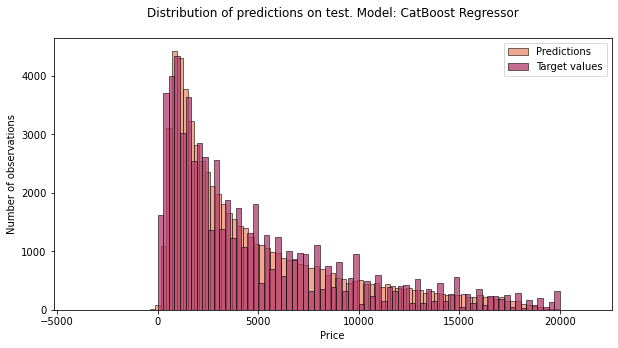

In [136]:
plt.figure(figsize=(10,5))
sns.histplot(x=final_model.predict(transformed_features_test), color=color[0], label='Predictions')
sns.histplot(x=target_test, color=color[3], label='Target values')
plt.ylabel('Number of observations')
plt.xlabel('Price')
plt.title('Distribution of predictions on test. Model: CatBoost Regressor\n')
plt.legend()
plt.show()

## Conclusion

At the first stage, variables that will be used to predict car price were selected: `VehicleType`, `RegistrationYear`, `Gearbox`, `Power`, `Model`, `Kilometer`, `RegistrationMonth`, `FuelType`, ` Brand`, `Repaired`. In addition, outliers and duplicates were removed from the data. Finally, missing values were filled in the variables.

Next, five ML models were fitted: Linear Regression, Decision Tree Regressor, Random Forest Regressor, CatBoost Regressor and LGBM Regressor. Predictions made by all of these models were compared with Dummy Regressor predictions.

As a result, CatBoostRegressor model was chosen as the best model according to the three criteria: prediction quality (score), prediction time, fitting time. It is recommended to use CatBoost Regressor to develop an application that will predict car price.